In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops

In [2]:
!git clone https://github.com/fxnnxc/crp_pytorch

fatal: destination path 'crp_pytorch' already exists and is not an empty directory.


In [3]:
def load_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.title("Image loaded successfully")
    return image

normalise = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )

preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalise
    ])

def deprocess(image):
    return image * torch.Tensor([0.229, 0.224, 0.225]).cuda()  + torch.Tensor([0.485, 0.456, 0.406]).cuda()


In [4]:
vgg = models.vgg16(pretrained=True)
vgg = vgg.cuda()
print(vgg)
modulelist = list(vgg.features.modules())

/home/summer_intern/anaconda3/envs/seongsu_lab/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/summer_intern/anaconda3/envs/seongsu_lab/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
def L2_norm(out):
    return out.norm()

# def L2_norm(out):
#     return out

In [6]:
def dd_helper(image, layer, iterations, lr, objective = L2_norm):        
    ## (1) image에 batchsize 1을 unsqueeze하고, VGG16에 넣기 위해서 data를 normalize하며,cuda에 데이터 복사
    input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
    ## (2) gradient 초기화
    vgg.zero_grad()
    ## (3) iteration 횟수 만큼 model에 역전파
    for i in range(iterations):
#         print('Iteration: ', i)
        out = input
        for j in range(layer):
            out = modulelist[j+1](out)
        ## L2 norm
        loss = objective(out)
#         print(loss,out)

        loss.backward()
#         out.backward(loss)
        input.data = input.data + lr * input.grad.data
    
    # Remove the batchsize index
    input = input.data.squeeze()
    
    # Change the order of the channel (RGB,x,y) -> (x,y,RGB)
    input = input.permute(1,2,0)

    # Ensure that pixel value are between 0 and 1.
    input = np.clip(deprocess(input).cpu(), 0, 1)
    im = Image.fromarray(np.uint8(input*255))
    return im

In [7]:
# def dd_helper(image, layer, iterations, lr):        
    
#     input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
#     vgg.zero_grad()
#     for i in range(iterations):
# #         print('Iteration: ', i)
#         out = input
#         for j in range(layer):
#             out = modulelist[j+1](out)
#         loss = out.norm()
#         loss.backward()
#         input.data = input.data + lr * input.grad.data
    
#     input = input.data.squeeze()
#     input.transpose_(0,1)
#     input.transpose_(1,2)
#     input = np.clip(deprocess(input).cpu(), 0, 1)
#     im = Image.fromarray(np.uint8(input*255))
#     return im

In [8]:

def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves, blend = 0.6, objective = L2_norm):
    """
    Recursively blur and downscale the input image.
    Each downscaled image is run through the optimize_image()
    function to amplify the patterns that the Inception model sees.
    
    Parameters:
    image: input으로 들어오는 image. (type: PIL Image)
    layer: Reference to a index that will be maximized
    iteration: Number of optimization iterations to perform.
    lr: learning rate, Scale for each step of the gradient ascent.
    octave_scale: pixel을 다운스케일
    num_octaves : size를 줄이는 횟수
    blend: blend가 1에 가까울 수록 기존의 이미지가 보존이 되고, 0에 가까울 수록 패턴이 보존이 됨
    
    Parameters passed to dd_helper():
    image: Downscale된 이미지
    layer: Reference to a tensor that will be maximized.
    iterations: Number of optimization iterations to perform.
    lr: learning rate, Scale for each step of the gradient ascent.
    """
    assert 0 <= layer <= 31, "Layer number must be between 0 to 31."
    if num_octaves>0:
        ## (1) Input Image에 Gaussian Blur처리
        ## 이를 통해서 Input image를 downscaling을 할 때 이미지의 artifacts가 훼손되는 것을 막음
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        
        ## (2) Downscale the Image
        if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
            size = image1.size
        else:
            size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
#         print(image1)
        image1 = image1.resize(size,Image.ANTIALIAS) ## ANTIALIAS -> Interpolation technique
#         image1 = image1.resize(size,Image.NEAREST)

        ## (3) 이미지를 deep dream에다가 recursive하게 넣음
        ## 남은 downscale 횟수를 하나 줄여서 넣음
        ## 이 결과로 num_octaves-1 만큼에서 deep_dream이 생성된 이미지가 output으로 나옴
        image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)

        ## 기존 이미지의 사이즈
        size = (image.size[0], image.size[1])
        
        ## (3)의 결과를 현재의 이미지 크기로 Upscaling함
        image1 = image1.resize(size,Image.ANTIALIAS)
        
        ## (4) 기존의 이미지와 새로운 이미지를 blending. 기존의 image의 비율이 0.6
        image = ImageChops.blend(image, image1, blend)
#     print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr, objective)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [9]:
# def deep_dream_vgg(image, layer, iterations, lr, octave_scale, num_octaves):
    
#     if num_octaves>0:
#         image1 = image.filter(ImageFilter.GaussianBlur(2))
#         if(image1.size[0]/octave_scale < 1 or image1.size[1]/octave_scale<1):
#             size = image1.size
#         else:
#             size = (int(image1.size[0]/octave_scale), int(image1.size[1]/octave_scale))
            
#         image1 = image1.resize(size,Image.ANTIALIAS)
#         image1 = deep_dream_vgg(image1, layer, iterations, lr, octave_scale, num_octaves-1)
#         size = (image.size[0], image.size[1])
#         image1 = image1.resize(size,Image.ANTIALIAS)
#         image = ImageChops.blend(image, image1, 0.6)
# #     print("-------------- Recursive level: ", num_octaves, '--------------')
#     img_result = dd_helper(image, layer, iterations, lr)
#     img_result = img_result.resize(image.size)
#     plt.imshow(img_result)
#     return img_result

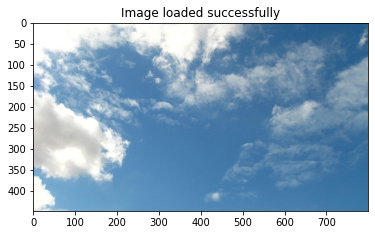

In [10]:
sky = load_image('sky-dd.jpeg')

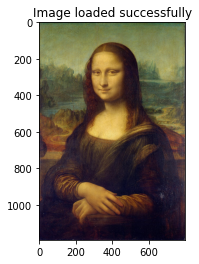

In [11]:
Ml = load_image('Mona_Lisa.jpg')

In [12]:
# flower = load_image('Flowers.jpg')
# guide_size = flower.size

# def guide_helper(image, layer):        
#     ## (1) image에 batchsize 1을 unsqueeze하고, VGG16에 넣기 위해서 data를 normalize하며,cuda에 데이터 복사
#     input = Variable(preprocess(image).unsqueeze(0).cuda(), requires_grad=True)
#     ## (2) gradient 초기화
#     vgg.zero_grad()
#     ## (3) iteration 횟수 만큼 model에 역전파
# #         print('Iteration: ', i)
#     out = input
#     for j in range(layer):
#         out = modulelist[j+1](out)
#     return out

# guide_features = guide_helper(flower,5)

In [13]:
# def objective_guide(dst):
#     x = dst.data[0].cpu().numpy()
#     y = guide_features.data[0].cpu().numpy()
#     ch, w, h = x.shape
#     x = x.reshape(ch, -1)
#     y = y.reshape(ch, -1)
#     A = x.T.dot(y)
#     diff = y[:, A.argmax(1)]
#     diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])).cuda()
#     print(diff)
#     print(diff.shape)

#     return diff

/home/summer_intern/anaconda3/envs/seongsu_lab/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
/home/summer_intern/anaconda3/envs/seongsu_lab/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


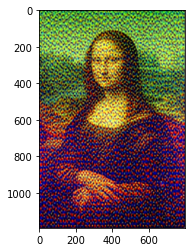

In [14]:
Ml_5 = deep_dream_vgg(Ml, 5, 10, 0.3, 2, 10)

In [15]:
# Ml_5 = deep_dream_vgg(Ml, 5, 10, 0.3, 2, 10, objective = objective_guide)

NameError: name 'objective_guide' is not defined

/home/summer_intern/anaconda3/envs/seongsu_lab/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
/home/summer_intern/anaconda3/envs/seongsu_lab/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


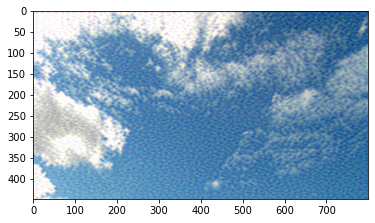

In [16]:
sky_5 = deep_dream_vgg(sky, 5, 5, 0.3, 2, 1)

In [ ]:
plt.imshow(sky_5)

In [ ]:
sky_5 = deep_dream_vgg(sky, 5, 5, 0.3, 2, 20)

In [ ]:
sky_5 = deep_dream_vgg(sky, 5, 5, 0.3, 2, 20)

In [ ]:
sky_7 = deep_dream_vgg(sky, 7, 4, 0.3, 3, 20)

In [ ]:
sky_7 = deep_dream_vgg(sky, 7, 4, 0.3, 3, 20)

In [ ]:
sky_10 = deep_dream_vgg(sky, 10, 3, 0.3, 2, 20)

In [ ]:
sky_12 = deep_dream_vgg(sky, 12, 2, 0.3, 2, 20)

In [ ]:
sky_14 = deep_dream_vgg(sky, 14, 3, 0.3, 2, 20)

In [ ]:
sky_17 = deep_dream_vgg(sky, 17, 3, 0.3, 2, 20)

In [ ]:
sky_19 = deep_dream_vgg(sky, 19, 3, 0.3, 2, 20)

In [ ]:
sky_21 = deep_dream_vgg(sky, 21, 3, 0.3, 2, 20)

In [ ]:
sky_24 = deep_dream_vgg(sky, 24, 5, 0.2, 2, 20)

In [ ]:
sky_26 = deep_dream_vgg(sky, 26, 5, 0.2, 2, 20)

In [ ]:
sky_26 = deep_dream_vgg(sky, 26, 5, 0.2, 2, 20)

In [ ]:
Ml_26 = deep_dream_vgg(Ml, 26, 8, 0.2, 2, 20,blend = 0.3)
plt.figure(figsize=(6,8))
plt.imshow(Ml_26)

In [ ]:
sky_28 = deep_dream_vgg(sky, 28, 5, 0.2, 2, 20)

In [ ]:
Ml_28 = deep_dream_vgg(Ml, 28, 8, 0.2, 2, 20)

In [ ]:
plt.figure(figsize=(6,8))
plt.imshow(Ml_28)

In [ ]:
sky_28 = deep_dream_vgg(sky, 28, 20, 0.2, 2, 20)

In [ ]:
sky_28 = deep_dream_vgg(sky, 28, 20, 0.2, 2, 20)